In [342]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tabula
import PyPDF2
import plotly.express as px
import plotly.graph_objects as go

# COVID-19 in Mexico

**The objective of this notebook is to make an exploratory data analysis of the confirmed cases of coronavirus in Mexico**

The data sources are the tables of positive confirmed cases in the [Daily technical releases](https://www.gob.mx/salud/documentos/coronavirus-covid-19-comunicado-tecnico-diario-238449) of the **General Division of Emidemiology** of the **Secretaría de Salud** of Mexico.

In [343]:
# to update please edit the date as the format below:
# ---- aaaa.mm.dd
date = '2020.03.24'

# local path of the file in my computer.
path = 'data\\mexico_data_sources\\Tablas de Casos Confirmados\\Tabla_casos_positivos_COVID-19_resultado_InDRE_'+date+'.pdf'

# Read data

In [350]:
def read_confirmed_pdf(path):
    """Read the tables of the positive confirmed cases that the General Division of Emidemiology emits everyday in a pdf file.
    Lee las tablas de casos confirmados positivos que emite la Dirección General de Epidemiología de manera diaria.
    
    Args:
        path(str not null, path to pdf file)
    
    Returns:
        DataFrame.
    """
    columns = ['Case Number', 'State', 'Sex', 'Age', 'Date Symptoms', 'Identification', 'Origin', 'Date of Arrive']
    
    # obtain the number of pages of the pdf file
    read_pdf = PyPDF2.PdfFileReader(path)
    number_of_pages = read_pdf.getNumPages()
    
    # We read all the pages of the document and store them
    # in a list full of Nones.
    dfs = [None]*number_of_pages
    for page in range(number_of_pages):

        if page==0:
            df = tabula.read_pdf(path, pages=str(page+1), area=[120,5,800,900], stream=True, pandas_options={'header':None})
            dfs[page] = df[0]

        elif page<(number_of_pages-1):
            df = tabula.read_pdf(path, pages=str(page+1), area=[30,15,800,900], stream=True, pandas_options={'header':None})
            dfs[page] = df[0]

        else:
            df = tabula.read_pdf(path, pages=str(page+1), area=[35,5,500,900], stream=True, pandas_options={'header':None})
            dfs[page] = df[0]
    
    # join all the DataFrame's in just one.
    out_df = pd.concat(dfs,ignore_index=True,sort=True)

    # rename the columns of the output DataFrame.
    d = dict(zip(out_df.columns.to_list(),columns))
    out_df = out_df.rename(d,axis=1)
    
    return out_df

In [351]:
df = read_confirmed_pdf(path)

We have to drop na's and fix two columns: **``State``** and **``Case Number``**

In [353]:
new_case_number = []
new_state = []
for i in range(len(df['State'])):
    if str(df['State'][i])=='nan':
        try:
            print(df['Case Number'][i].split(' ',1)[0])
            print(df['Case Number'][i].split(' ',1)[1])
            new_state.append(df['Case Number'][i].split(' ',1)[1])
            new_case_number.append(df['Case Number'][i].split(' ',1)[0])
        except:
            new_state.append(df['State'][i])
            new_case_number.append(df['Case Number'][i])
    else:
        new_state.append(df['State'][i])
        new_case_number.append(df['Case Number'][i])

        
df['State'] = new_state
df['Case Number'] = new_case_number
df = df.dropna(axis=0,thresh=5)
df

,Case Number,State,Sex,Age,Date Symptoms,Identification,Origin,Date of Arrive
0,1,CIUDAD DE MÉXICO,M,35,22/02/2020,confirmado,Italia,22/02/2020
1,2,SINALOA,M,41,22/02/2020,confirmado,Italia,21/02/2020
2,3,CIUDAD DE MÉXICO,M,59,23/02/2020,confirmado,Italia,22/02/2020
3,4,COAHUILA,F,20,27/02/2020,confirmado,Italia,25/02/2020
4,5,CHIAPAS,F,18,25/02/2020,confirmado,Italia,25/02/2020
...,...,...,...,...,...,...,...,...
400,401,YUCATÁN,F,30,19/03/2020,confirmado,Francia,18/03/2020
401,402,YUCATÁN,F,40,14/03/2020,confirmado,Contacto,NA
402,403,CIUDAD DE MÉXICO,M,38,10/03/2020,confirmado,Contacto,NA
403,404,CIUDAD DE MÉXICO,M,64,15/03/2020,confirmado,Francia,11/03/2020


## Add new column: ``Class``

* This column contains the age range **(classes in decades)** that corresponds to the person.


* This will help us to make a ``sns.countplot()`` where we will see the number of confirmed cases per age class in Mexico.


* The values that this column takes are:

    * ``['0-9', '10-19', '20-29', '30-39','40-49','50-59','60-69','70-79','80-89','90-99']``

In [354]:
classes = ['0-9', '10-19', '20-29', '30-39','40-49','50-59','60-69','70-79','80-89','90-99']

new_col = []

for age in df['Age']:# for each age
    for c in classes: # for each class
        lst = c.split('-')
        lst = list(map(int,lst))
        
        # append the corresponding class
        if (age>=lst[0]) & (age<=lst[1]):
            new_col.append(c) 

# add the new 'Class' column
df['Class'] = new_col

# Exploratory Data Analysis

In [355]:
df.head()

,Case Number,State,Sex,Age,Date Symptoms,Identification,Origin,Date of Arrive,Class
0,1,CIUDAD DE MÉXICO,M,35,22/02/2020,confirmado,Italia,22/02/2020,30-39
1,2,SINALOA,M,41,22/02/2020,confirmado,Italia,21/02/2020,40-49
2,3,CIUDAD DE MÉXICO,M,59,23/02/2020,confirmado,Italia,22/02/2020,50-59
3,4,COAHUILA,F,20,27/02/2020,confirmado,Italia,25/02/2020,20-29
4,5,CHIAPAS,F,18,25/02/2020,confirmado,Italia,25/02/2020,10-19


In [356]:
df.describe()

,Case Number,Age
count,405.000000,405.000000
mean,203.000000,41.400000
std,117.057678,15.325769
min,1.000000,0.000000
25%,102.000000,30.000000
50%,203.000000,39.000000
75%,304.000000,53.000000
max,405.000000,80.000000


In [357]:
# Top 5 ages with more confirmed cases

df['Age'].value_counts().head(5)

30    16
27    15
35    13
29    13
31    13
Name: Age, dtype: int64

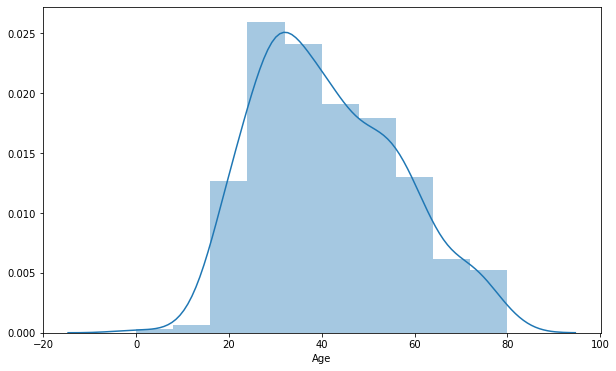

In [358]:
# histogram of age

plt.subplots(figsize=(10,6))
sns.distplot(df['Age'],bins=10)
plt.show()

In [359]:
# useful functions

def find(x,lab):
    """Finds the position (int) of the
    first occurrence of an element in 
    an array like object.
    
    Args:
        x:
            array like object, iterable where we are going to find position
        lab:
            str or int, the object we want to find
    
    Returns:
        int, position of the searched value
    """
    c = 0
    for element in x:
        if element==lab:
            return c
        else:
            c = c + 1
def get_max_index(df,column):
    """Get the index of the maximun value of a column in a dataframe.
    
    Args:
        df:
            pandas.DataFrame
        column:
            str, column of the searched max index
    
    Returns:
        str, index of the df
    """
    return df[df[column]==df[column].max()].index.to_list()[0]

In [360]:
# plotly bar chart for confirmed cases per age

# df of confirmed cases
classes_counts =pd.DataFrame(df['Class'].value_counts())
ix = classes_counts.index.to_list()
classes_counts =pd.DataFrame(df['Class'].value_counts(), index=pd.Index(ix,name='Class'))
classes_counts = classes_counts.rename({'Class':'Confirmed'},axis=1)
classes_counts = classes_counts.reindex(classes)

# assign red color to the class with
# the most confirmed cases
lab = get_max_index(df=classes_counts,column='Confirmed')
colors= ['coral']*len(classes)
colors[find(classes_counts.index,lab)] = 'crimson'

# figure
fig = go.Figure(
    data=[
        go.Bar(
            x=classes, y=classes_counts['Confirmed'],
            text=classes_counts['Confirmed'],
            textposition='outside',
            marker = {
                'color':colors
            }  
        )
    ]
)

# layout
fig.update_layout(
    title='Confirmed cases per age in Mexico',
    xaxis_title="Age",
    yaxis_title=None,
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    )
)
fig.write_image("figs/confirmed_per_age2.png")
fig.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


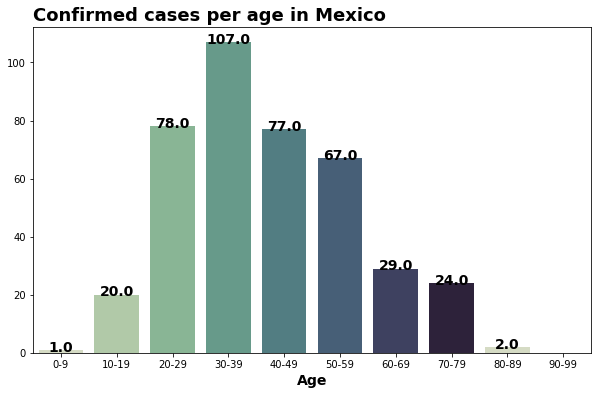

In [361]:
# Confirmed cases distribution per age range

plt.subplots(figsize=(10,6))
plot = sns.countplot(data=df,x='Class', order=classes,palette=sns.cubehelix_palette(8, start=.5, rot=-.75))

# add data labels:
for i, bar in enumerate(plot.axes.patches):
    h = bar.get_height()
    plot.axes.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        '{}'.format(h),  # y label
        ha='center', 
        va='center', 
        fontweight='bold',
        color='black',
        size=14)
plt.xlabel('Age',size=14,fontweight='bold')
plt.ylabel(None)
plt.title('Confirmed cases per age in Mexico', size=18,fontweight='bold',loc='left')
plt.savefig('figs\confirmed_per_age.png')
plt.show()

In [363]:
fem = df[df['Sex']=='F']
fem = fem['Class'].value_counts()
fem = list(fem.reindex(classes))


males = df[df['Sex']=='M']
males = males['Class'].value_counts()
males = list(males.reindex(classes))

for i in range(len(fem)):
    if str(males[i])=='nan':
        males[i]=0
    
    if str(fem[i])=='nan':
        fem[i]=0


fig = go.Figure(
    data=[
        go.Bar(
            name='Women',
            x=classes,
            y=fem,
            text=list(map(int,fem)),
            textposition='outside',
            marker_color = 'salmon'
        ),
        go.Bar(
            name='Men',
            x=classes,
            y=males,
            text=list(map(int,males)),
            textposition='outside',
            marker_color = 'royalblue'
        )
    ]
)

# layout
fig.update_layout(
    title='Confirmed cases per age and sex in Mexico',
    xaxis_title="Age",
    yaxis_title=None,
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    )
)
fig.write_image("figs/confirmed_per_age-sex2.png")
fig.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


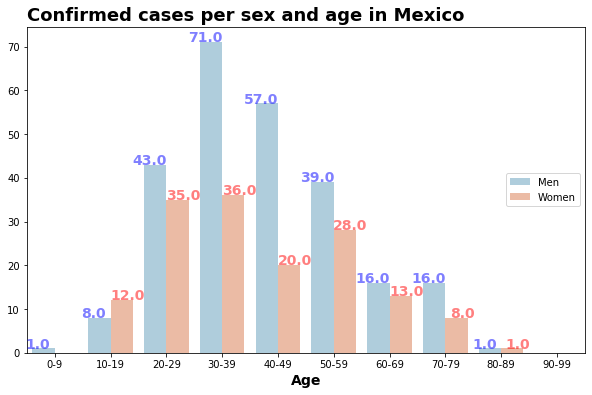

In [364]:
# Confirmed cases per sex and age in Mexico

plt.subplots(figsize=(10,6))
plot = sns.countplot(data=df,x='Class',hue='Sex',palette='RdBu_r', order=classes)

#add data labels:
n = int(len(list(plot.axes.patches))/2) # count of bars/2
for i, bar in enumerate(plot.axes.patches):
    h = bar.get_height()
    
    if i in range(n):
        plot.axes.text(
            i-0.3, # bar index (x coordinate of text)
            h+1, # y coordinate of text
            '{}'.format(h),  # y label
            ha='center', 
            va='center', 
            fontweight='bold',
            color='blue',
            alpha=0.5,
            size=14)
    else:
        plot.axes.text(
            i - n + 0.3, # bar index (x coordinate of text)
            h+1, # y coordinate of text
            '{}'.format(h),  # y label
            ha='center', 
            va='center', 
            fontweight='bold',
            color='red',
            alpha=0.5,
            size=14)
        
    
plt.xlabel('Age',size=14,fontweight='bold')
plt.ylabel(None)
plt.title('Confirmed cases per sex and age in Mexico', size=18,fontweight='bold',loc='left')
plt.legend(labels=('Men','Women'),loc='right')
plt.savefig('figs\confirmed_per_age_sex.png')
plt.show()

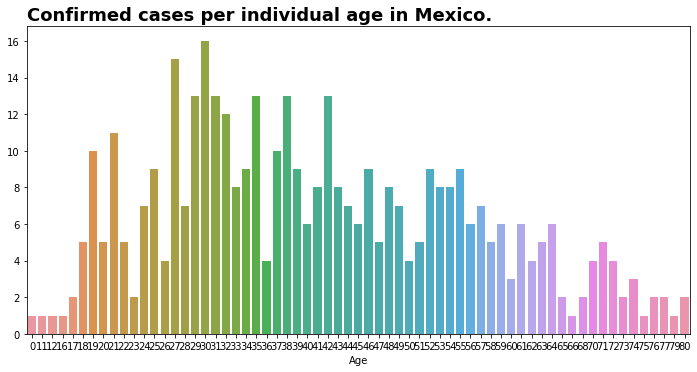

30    16
27    15
35    13
29    13
31    13
      ..
75     1
16     1
12     1
11     1
0      1
Name: Age, Length: 65, dtype: int64


In [366]:
# Confirmed cases per individual age

plt.subplots(figsize=(10,5))
sns.countplot(data=df,
             x='Age',
             orient='h')
plt.tight_layout()
plt.ylabel(None)
plt.title('Confirmed cases per individual age in Mexico.', size=18,fontweight='bold',loc='left')
plt.savefig('figs\confirmed_individual_age.png', bbox_inches = 'tight')
plt.show()

# We can see that the age with more confirmed cases is 27 y/o.
print(df['Age'].value_counts())

In [367]:
# Basic information of the people with the highest and lowest age that have been confirmed.

df[(df['Age']==df['Age'].max()) | (df['Age'] == df['Age'].min())]

,Case Number,State,Sex,Age,Date Symptoms,Identification,Origin,Date of Arrive,Class
73,74,NUEVO LEÓN,F,80,09/03/2020,confirmado,España,12/03/2020,80-89
198,199,JALISCO,M,80,14/03/2020,confirmado,Estados Unidos,14/03/2020,80-89
209,210,CIUDAD DE MÉXICO,M,0,16/03/2020,confirmado,Contacto,NA,0-9


In [368]:
states = df['State'].value_counts().index.to_list()

vals = list(df['State'].value_counts())

fig = go.Figure(
    data=[
        go.Bar(
            x=states,
            y=vals,
            orientation='v',
            text=list(map(int,vals)),
            marker= dict(
                color='rgba(50, 171, 96, 0.6)',
                line=dict(
                    color='rgba(50, 171, 96, 1.0)',
                    width=2)
            )
        )
    ]
)

# layout
fig.update_layout(
    title='Confirmed cases per State in Mexico',
    xaxis_title="State",
    yaxis_title=None,
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    )
)
fig.write_image("figs/confirmed_state2.png")
fig.show()

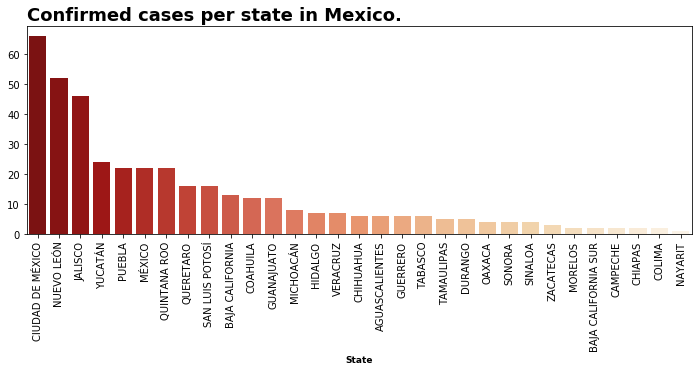

In [369]:
plt.subplots(figsize=(10,5))
sns.countplot(data=df,x='State',
              orient="h",
              order=df['State'].value_counts().index,
              palette='OrRd_r')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel(None)
plt.xlabel('State',size=9,fontweight='bold')
plt.title('Confirmed cases per state in Mexico.', size=18,fontweight='bold',loc='left')
plt.savefig('figs\confirmed_state.png',bbox_inches = 'tight')
plt.show()

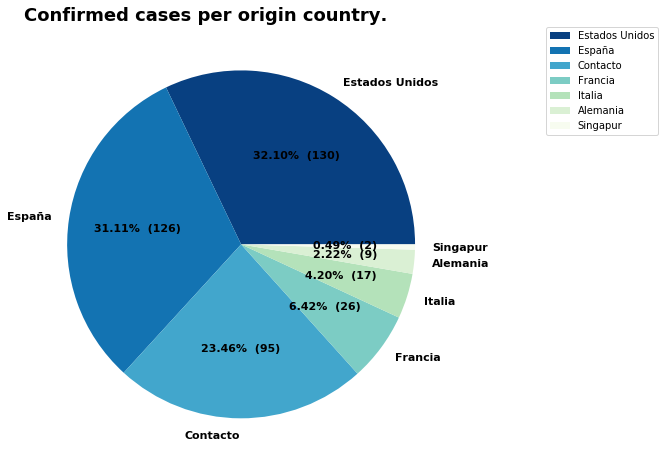

In [372]:
# pie chart of confirmed cases per origin country

origin_df = pd.DataFrame(df['Origin'].value_counts())
ix = origin_df.index.to_list()
origin_df = pd.DataFrame(df['Origin'].value_counts(),
                        index = pd.Index(ix,name='Origin'))
origin_df = origin_df.rename({'Origin':'Confirmed'},axis=1)
origin_df.plot.pie(subplots=True, figsize=(8, 8), colormap='GnBu_r',
                   autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(origin_df['Confirmed'])/100),
                  textprops={'fontsize': 11, 'fontweight':'bold'})
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left',borderaxespad=0.)
plt.ylabel(None)
plt.title('Confirmed cases per origin country.', size=18,fontweight='bold',loc='left')
plt.savefig('figs\confirmed_origin.png',bbox_inches = 'tight')
plt.show()

In [373]:
import plotly.express as px
fig = px.pie(
    origin_df,
    values='Confirmed',
    title='Confirmed cases per origin country',
    names=origin_df.index,
    color_discrete_sequence=px.colors.sequential.GnBu_r
)
fig.update_traces(textposition='outside', textinfo='percent+value', showlegend=True, sort=True)
fig.write_image("figs/confirmed_origin2.png")
fig.show()

In [375]:
sex = df['Sex'].value_counts().index.to_list()

vals = list(df['Sex'].value_counts())

In [399]:
y = list(df['Sex'].value_counts())
x = ['Men','Women']

colors = ['darkblue','firebrick']

fig = go.Figure()

for xi,yi,color in zip(x,y,colors):
    fig.add_trace(
        go.Bar(
            name=xi,
            x=[xi],
            y=[yi],
            marker_color=[color]
        )
    )

annotations=[]
for yi,xi in zip(y,x):
    annotations.append(
        dict(
            x=xi,
            y=yi,
            #xref="x",
            #yref="y",
            text='{}'.format(int(yi)),
            yshift=10,
            showarrow=False,
            #arrowhead=7
        )
    )

fig.update_layout(
    title='Confirmed cases in Mexico per Sex',
    xaxis_title="Sex",
    yaxis_title="Confirmed Cases",
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    ),
    annotations=annotations,
    colorscale=dict(
        sequential='rdbu'
    )
)
fig.write_image("figs/bar_mexico_sex.png")
fig.show()